In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import glob
from math import sqrt
from pprint import pprint
from time import gmtime, strftime
SPINE_COLOR = 'gray'
sns.set(style="whitegrid") # or "darkgrid"

In [3]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'pdf',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8,       #'text.fontsize': 8, # was 10
              'legend.fontsize': 6.5, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'lines.linewidth' : 0.4,
              'lines.markersize' : 0.4,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

linewidth=497
DPI=96
#latexify(fig_width=linewidth/DPI, fig_height=int(linewidth/2.3/DPI))
latexify(fig_width=linewidth/DPI/1.7, fig_height=int(linewidth/2.3/DPI))

.\20191207-004432_GENI_107400msgs-100-100-N\
Sent by Client: Received by Server:
 107648 107648
Retransmissions by Client: Re-Retransmissions: Successful Retransmissions: 
 253 0 253
Retransmissions rate: 0.24 %
.\20191207-131731_GENI_107400msgs_100-100-L\
Sent by Client: Received by Server:
 107773 107773
Retransmissions by Client: Re-Retransmissions: Successful Retransmissions: 
 392 0 392
Retransmissions rate: 0.36 %
.\20191207-165925_GENI_107400msgs_100-100-F\
Sent by Client: Received by Server:
 107753 107753
Retransmissions by Client: Re-Retransmissions: Successful Retransmissions: 
 373 0 373
Retransmissions rate: 0.35 %


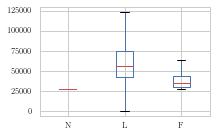

In [60]:
# GENI
dfAll = pd.DataFrame()
for f in glob.iglob('./*201912*107400*/', recursive=True): # /*directoryRegExp*/ to reduce output (long runtime)
    dfapp = pd.read_csv(f+'serverAppOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'length', 'msg_number', 'onewaydelay'])
    dfstream = pd.read_csv(f+'serverStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'byte_offset', 'length', 'msg_number', 'onewaydelay'])
    dfclient = pd.read_csv(f+'clientStreamOutput', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'streamid', 'msg_number'])
    dfkpi = pd.read_csv(f+'firstKPIs', delim_whitespace=True ,names = 
                                        ['seconds_offset', 'bytes-in-flight', 'nb-ret', 'rtt_min', 'crtt', 'sendtime', 
                                         'latest_msg', 'currentackdelay', 'srtt', 'rttvar', 'maxackdelay', 'state'])
    print(f)
    
    msgs_sent = dfclient.msg_number.size
    msgs_received = dfstream.msg_number.size
    
    dfclient['duplicate'] = dfclient.msg_number.duplicated()
    
    retryList = [];
    retryWithoutDuplicates = [];
    for i, value in enumerate(dfclient.duplicate):
        if(value):
            retryList.append(dfclient.msg_number[i])
            if(dfclient.msg_number[i] not in retryWithoutDuplicates):
                retryWithoutDuplicates.append(dfclient.msg_number[i])
    
    retriesPerMsg = [];
    for msgID in retryList:
        if(msgID not in retriesPerMsg):
            retriesPerMsg.append(retryList.count(msgID))
    
    retries = pd.Series(retriesPerMsg)
    
    #look if the retransmit messages have arrived
    arrivedRetransmits = [];

    for msg in retryWithoutDuplicates:
        if dfstream.msg_number[dfstream.msg_number == msg].size > 0:
            arrivedRetransmits.append(msg)
    
    
    print('Sent by Client:', 'Received by Server:\n', 
          msgs_sent, msgs_received)
    print('Retransmissions by Client:', 'Re-Retransmissions:', 'Successful Retransmissions: \n',
          len(retryList), len(retryList)-len(retryWithoutDuplicates), len(arrivedRetransmits))
    print('Retransmissions rate:', round((len(retryList)/msgs_sent)*100, 2), '%')
    
    
    dfkpi.index = range(len(dfkpi))

    if '-N' in f:
        dfAll['N'] = dfkpi['crtt']
    if '-L' in f:
        dfAll['L'] = dfkpi['crtt']
    if '-F' in f:
        dfAll['F'] = dfkpi['crtt']
        
        
#print(dfAll)
dfAll.boxplot(showfliers=False)
    